In [ ]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
from sentence_transformers import SentenceTransformer


nltk.download("stopwords")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_csv("all_tickets_processed_improved_v3.csv")
df.head()


,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [ ]:
df.shape


(47837, 2)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47837 entries, 0 to 47836
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Document     47837 non-null  object
 1   Topic_group  47837 non-null  object
dtypes: object(2)
memory usage: 747.6+ KB


In [ ]:
df.isnull().sum()


,0
Document,0
Topic_group,0


In [ ]:
df = df.dropna(subset=["Document", "Topic_group"])
df = df.drop_duplicates()


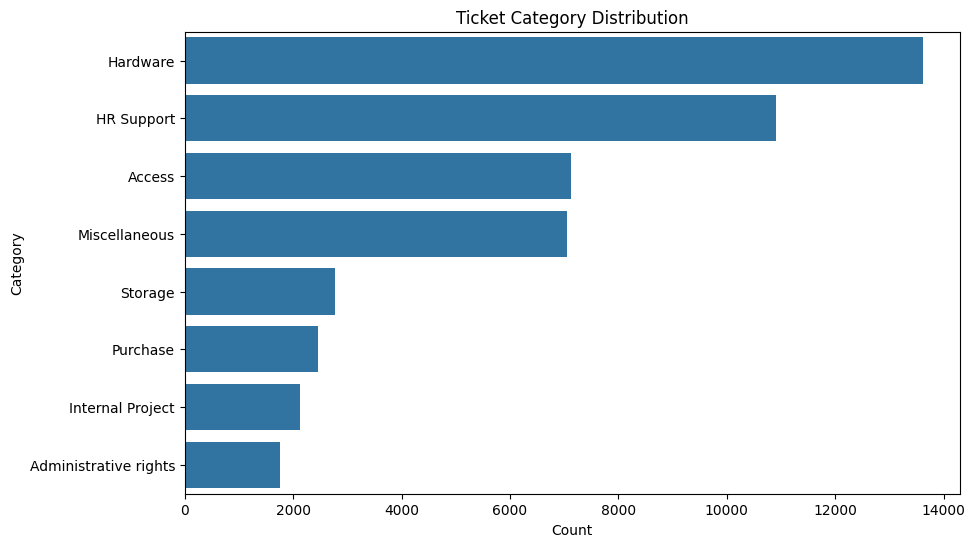

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(
    y=df["Topic_group"],
    order=df["Topic_group"].value_counts().index
)
plt.title("Ticket Category Distribution")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()


In [ ]:
df["Topic_group"].nunique()


8

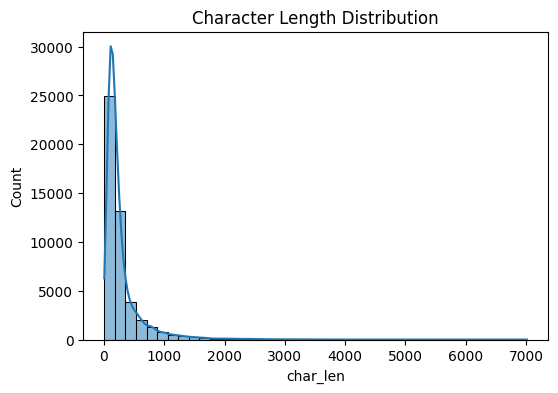

In [ ]:
df["char_len"] = df["Document"].str.len()

plt.figure(figsize=(6,4))
sns.histplot(df["char_len"], bins=40, kde=True)
plt.title("Character Length Distribution")
plt.show()


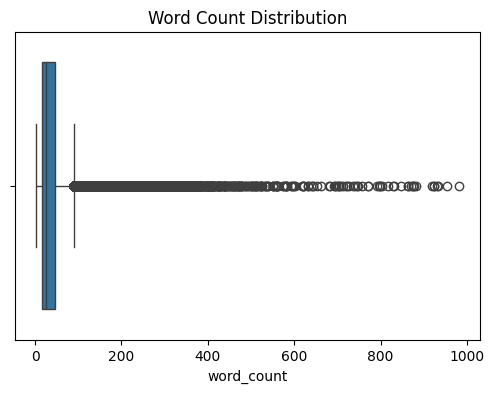

In [ ]:
df["word_count"] = df["Document"].apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
sns.boxplot(x=df["word_count"])
plt.title("Word Count Distribution")
plt.show()


In [ ]:
df.groupby("Topic_group")["word_count"].mean().sort_values(ascending=False)


,word_count
Topic_group,
Hardware,56.273041
Administrative rights,50.361932
Miscellaneous,42.953966
HR Support,37.766651
Internal Project,37.706937
Access,35.600000
Purchase,34.932630
Storage,34.409795


In [ ]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_desc"] = df["Document"].apply(clean_text)


In [ ]:
X = df["clean_desc"]
y = df["Topic_group"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
tfidf = TfidfVectorizer(
    max_df=0.9,
    min_df=5,
    ngram_range=(1,2),
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [ ]:

embedder = SentenceTransformer("all-MiniLM-L6-v2")

X_train_emb = embedder.encode(
    X_train.tolist(),
    batch_size=32,
    show_progress_bar=True
)

X_test_emb = embedder.encode(
    X_test.tolist(),
    batch_size=32,
    show_progress_bar=True
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1196 [00:00<?, ?it/s]

Batches:   0%|          | 0/299 [00:00<?, ?it/s]

In [ ]:
def train_and_evaluate_model(
    model,
    model_name,
    X_train,
    X_test,
    y_train,
    y_test,
    results_df
):
    start_time = time.time()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    train_time = time.time() - start_time

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

    try:
        y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
        else:
            roc = np.nan
            raise Exception

        roc = roc_auc_score(
            y_test_bin,
            y_score,
            average="macro",
            multi_class="ovr"
        )
    except:
        roc = np.nan

    results_df.loc[len(results_df)] = [
        model_name, acc, prec, rec, f1, roc, train_time
    ]

    return results_df


In [ ]:
results_df = pd.DataFrame(columns=[
    "Model",
    "Accuracy",
    "Precision",
    "Recall",
    "F1",
    "ROC_AUC",
    "Train_Time(sec)"
])


In [ ]:
results_df = train_and_evaluate_model(
    MultinomialNB(),
    "MultinomialNB",
    X_train_tfidf,
    X_test_tfidf,
    y_train,
    y_test,
    results_df
)


In [ ]:
results_df = train_and_evaluate_model(
    LogisticRegression(max_iter=3000),
    "LogisticRegression",
    X_train_tfidf,
    X_test_tfidf,
    y_train,
    y_test,
    results_df
)


In [ ]:
results_df = train_and_evaluate_model(
    SGDClassifier(loss="hinge"),
    "SGDClassifier",
    X_train_tfidf,
    X_test_tfidf,
    y_train,
    y_test,
    results_df
)


In [ ]:
results_df = train_and_evaluate_model(
    LinearSVC(class_weight="balanced"),
    "LinearSVC",
    X_train_tfidf,
    X_test_tfidf,
    y_train,
    y_test,
    results_df
)


In [ ]:
results_df = train_and_evaluate_model(
    DecisionTreeClassifier(random_state=42),
    "DecisionTree",
    X_train_tfidf,
    X_test_tfidf,
    y_train,
    y_test,
    results_df
)


In [ ]:
results_df = train_and_evaluate_model(
    RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),
    "RandomForest",
    X_train_tfidf,
    X_test_tfidf,
    y_train,
    y_test,
    results_df
)


In [ ]:
results_df = train_and_evaluate_model(
    KNeighborsClassifier(n_neighbors=5),
    "KNN",
    X_train_tfidf,
    X_test_tfidf,
    y_train,
    y_test,
    results_df
)


In [ ]:
emb_model = LinearSVC(class_weight="balanced")
emb_model.fit(X_train_emb, y_train)


LinearSVC(class_weight='balanced')

In [ ]:

TFIDF_WEIGHT = 0.6
EMB_WEIGHT = 0.4

tfidf_scores = best_model.decision_function(X_test_tfidf)
emb_scores = emb_model.decision_function(X_test_emb)

ensemble_scores = (
    TFIDF_WEIGHT * tfidf_scores +
    EMB_WEIGHT * emb_scores
)

ensemble_preds = best_model.classes_[np.argmax(ensemble_scores, axis=1)]

acc = accuracy_score(y_test, ensemble_preds)
prec = precision_score(y_test, ensemble_preds, average="macro", zero_division=0)
rec = recall_score(y_test, ensemble_preds, average="macro", zero_division=0)
f1 = f1_score(y_test, ensemble_preds, average="macro", zero_division=0)

try:
    roc = roc_auc_score(
        label_binarize(y_test, classes=best_model.classes_),
        ensemble_scores,
        average="macro",
        multi_class="ovr"
    )
except:
    roc = np.nan

results_df.loc[len(results_df)] = [
    "Ensemble_TFIDF+Embedding",
    acc, prec, rec, f1, roc, np.nan
]


In [ ]:
results_df


,Model,Accuracy,Precision,Recall,F1,ROC_AUC,Train_Time(sec)
0,MultinomialNB,0.747701,0.881093,0.626528,0.686851,0.955530,0.146095
1,LogisticRegression,0.857546,0.899461,0.813801,0.849775,0.987451,27.105628
2,SGDClassifier,0.859323,0.887580,0.829640,0.855066,0.984289,1.334349
3,LinearSVC,0.862458,0.859643,0.863678,0.861443,0.985333,3.563509
4,DecisionTree,0.759406,0.775496,0.754689,0.764542,0.858443,60.210726
5,RandomForest,0.823370,0.885699,0.769791,0.815060,0.981263,523.783034
6,KNN,0.741325,0.768506,0.723849,0.741906,0.919217,25.834517
7,Ensemble_TFIDF+Embedding,0.867684,0.861505,0.875077,0.867859,0.986724,NaN


In [ ]:
results_df.sort_values(by="F1", ascending=False)


,Model,Accuracy,Precision,Recall,F1,ROC_AUC,Train_Time(sec)
7,Ensemble_TFIDF+Embedding,0.867684,0.861505,0.875077,0.867859,0.986724,NaN
3,LinearSVC,0.862458,0.859643,0.863678,0.861443,0.985333,3.563509
2,SGDClassifier,0.859323,0.887580,0.829640,0.855066,0.984289,1.334349
1,LogisticRegression,0.857546,0.899461,0.813801,0.849775,0.987451,27.105628
5,RandomForest,0.823370,0.885699,0.769791,0.815060,0.981263,523.783034
4,DecisionTree,0.759406,0.775496,0.754689,0.764542,0.858443,60.210726
6,KNN,0.741325,0.768506,0.723849,0.741906,0.919217,25.834517
0,MultinomialNB,0.747701,0.881093,0.626528,0.686851,0.955530,0.146095


In [ ]:
best_row = results_df.sort_values(
    by=["F1", "ROC_AUC"],
    ascending=False
).iloc[0]

best_model_name = best_row["Model"]
best_model_name


'Ensemble_TFIDF+Embedding'

In [ ]:
if best_model_name == "Ensemble_TFIDF+Embedding":
    print("Best model is ENSEMBLE (TF-IDF + Embeddings)")

    best_tfidf_model = LinearSVC(class_weight="balanced")
    best_tfidf_model.fit(X_train_tfidf, y_train)

    best_emb_model = LinearSVC(class_weight="balanced")
    best_emb_model.fit(X_train_emb, y_train)

    best_model = None

elif best_model_name == "LinearSVC":
    best_model = LinearSVC(class_weight="balanced")
    best_model.fit(X_train_tfidf, y_train)

elif best_model_name == "LogisticRegression":
    best_model = LogisticRegression(max_iter=3000, n_jobs=-1)
    best_model.fit(X_train_tfidf, y_train)

elif best_model_name == "SGDClassifier":
    best_model = SGDClassifier(loss="hinge", max_iter=3000)
    best_model.fit(X_train_tfidf, y_train)

elif best_model_name == "MultinomialNB":
    best_model = MultinomialNB()
    best_model.fit(X_train_tfidf, y_train)

else:
    raise ValueError(f"Unexpected best model: {best_model_name}")


Best model is ENSEMBLE (TF-IDF + Embeddings)


In [ ]:
if best_model_name != "Ensemble_TFIDF+Embedding":
    final_preds = best_model.predict(X_test_tfidf)

    cm = confusion_matrix(y_test, final_preds)

    plt.figure(figsize=(9,6))
    sns.heatmap(cm, cmap="Blues", annot=False)
    plt.title(f"Confusion Matrix – {best_model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [ ]:
tfidf_scores = best_tfidf_model.decision_function(X_test_tfidf)
emb_scores = best_emb_model.decision_function(X_test_emb)

ensemble_scores = (
    TFIDF_WEIGHT * tfidf_scores +
    EMB_WEIGHT * emb_scores
)

ensemble_preds = best_tfidf_model.classes_[
    np.argmax(ensemble_scores, axis=1)
]


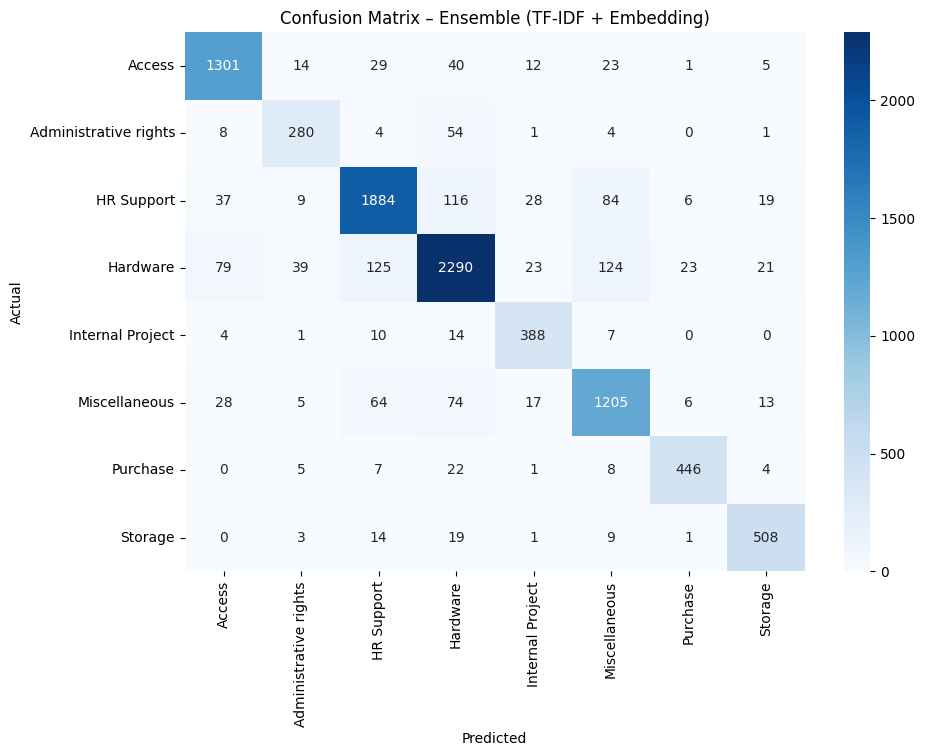

In [ ]:
labels = best_tfidf_model.classes_

plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion Matrix – Ensemble (TF-IDF + Embedding)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
CATEGORY_NORMALIZATION = {
    "Hardware": "Infrastructure Issue",
    "Network": "Infrastructure Issue",

    "Software": "Application Issue",
    "Email": "Application Issue",
    "Server": "Application Issue",

    "Purchase": "Service Request",
    "Access": "Service Request",
    "Account": "Service Request",
    "Administrative rights": "Service Request",

    "General": "General Inquiry"
}


def normalize_category(predicted_grp):
    return CATEGORY_NORMALIZATION.get(predicted_grp, predicted_grp)


In [ ]:
def ensemble_predict(text):
    clean = clean_text(text)
    tfidf_vec = tfidf.transform([clean])
    tfidf_score = best_tfidf_model.decision_function(tfidf_vec)

    emb_vec = embedder.encode([text])
    emb_score = emb_model.decision_function(emb_vec)

    combined = TFIDF_WEIGHT * tfidf_score + EMB_WEIGHT * emb_score

    idx = np.argmax(combined)
    raw_group = best_tfidf_model.classes_[idx]

    confidence = 1 / (1 + np.exp(-np.max(combined)))

    return raw_group, round(float(confidence), 3)


In [ ]:
BASE_PRIORITY = {
    "Infrastructure Issue": "High",
    "Application Issue": "Medium",
    "Service Request": "Low",
    "General Inquiry": "Low"
}

HIGH_CONF = 0.75
LOW_CONF = 0.55

def resolve_priority(final_group, confidence):
    base_priority = BASE_PRIORITY.get(final_group, "Low")

    if confidence < LOW_CONF:
        return "Manual Review"

    if final_group == "Service Request" and confidence < HIGH_CONF:
        return "Manual Review"

    return base_priority



In [ ]:
def predict_ticket_final(text):
    raw_group, confidence = ensemble_predict(text)

    final_group = normalize_category(raw_group)
    priority = resolve_priority(final_group, confidence)

    action = "Auto Route" if priority != "Manual Review" else "Manual Review"

    return {
        "Raw_Group": raw_group,
        "Final_Group": final_group,
        "Priority": priority,
        "Confidence": confidence,
        "Action": action
    }


In [ ]:
predict_ticket_final("Unable to connect to VPN after laptop update")


{'Raw_Group': 'Hardware',
 'Final_Group': 'Infrastructure Issue',
 'Priority': 'High',
 'Confidence': 0.806,
 'Action': 'Auto Route'}

In [ ]:
predict_ticket_final("Request for installation of new software")


{'Raw_Group': 'Administrative rights',
 'Final_Group': 'Service Request',
 'Priority': 'Manual Review',
 'Confidence': 0.551,
 'Action': 'Manual Review'}

In [ ]:
predict_ticket_final("Email server is down since morning")


{'Raw_Group': 'Hardware',
 'Final_Group': 'Infrastructure Issue',
 'Priority': 'High',
 'Confidence': 0.61,
 'Action': 'Auto Route'}

#  Interpretation of Results & System Behavior

This section provides a clear interpretation of the model’s performance, decision-making logic, and its real-world impact on customer support operations.

---

##  Model Performance Interpretation

Multiple machine learning models were trained and evaluated using accuracy, precision, recall, F1-score, and ROC-AUC. Among all evaluated models, the ensemble of TF-IDF and sentence embeddings achieved the best overall performance.

Key observations include:
- The ensemble model achieved the highest macro F1-score, indicating a strong balance between precision and recall across all ticket categories.
- A high ROC-AUC value (close to 1.0) demonstrates excellent class separability.
- Linear models such as LinearSVC and SGDClassifier consistently outperformed tree-based models on text data.
- Tree-based models (Decision Tree and Random Forest) showed lower recall and significantly higher training time, making them less suitable for large-scale text classification tasks.

Overall, the ensemble model benefits from combining TF-IDF features, which capture domain-specific keywords, with sentence embeddings, which capture semantic meaning and paraphrases. This combination reduces errors caused by vocabulary variation and ambiguous wording.

---

## Confusion Matrix Interpretation

The confusion matrix exhibits strong diagonal dominance, indicating that the majority of tickets are classified correctly.

Most misclassifications occur between semantically similar categories such as infrastructure and application-related issues or service requests and access-related tickets. These overlaps are common in real-world IT support data where category boundaries are not strictly defined.

This behavior is expected and acceptable, as the system mitigates the impact of such ambiguities through semantic label normalization and confidence-aware routing.

---

## Ticket Categorization Logic

Ticket categorization follows a two-stage process:

First, the ensemble model predicts an operational category based on historical ticket data.  
Second, the predicted category is normalized into a human-readable semantic category.

Examples of semantic normalization include:
- Hardware → Infrastructure Issue  
- Administrative rights → Service Request  
- Software → Application Issue  

This approach bridges the gap between noisy dataset labels and business-friendly categorizations, making the system easier to interpret and use by support teams.

---

## Priority Assignment Interpretation

Priority assignment is handled using a hybrid decision-support approach rather than relying solely on machine learning predictions.

Base priority is determined by the final ticket category:
- Infrastructure Issue → High priority  
- Application Issue → Medium priority  
- Service Request → Low priority  

In addition, confidence-aware rules are applied:
- Low-confidence predictions are routed for manual review.
- Service requests require higher confidence before being auto-routed.

This design ensures that critical incidents are escalated quickly while ambiguous or low-risk requests receive appropriate human oversight.

---

## Routing Decision Interpretation

Each ticket is assigned an action based on its predicted category, priority, and confidence level.

- Auto Route is used for high-confidence and clearly defined cases.
- Manual Review is enforced for low-confidence or sensitive service requests.

This routing strategy prevents blind automation and aligns with real-world enterprise support workflows.

---

## Business Impact Interpretation

From an operational perspective, this system:
- Reduces manual effort required for ticket triage.
- Improves response time for high-priority incidents.
- Maintains safety through confidence-based decision making.
- Ensures consistent and scalable ticket classification.
- Supports large volumes of support requests efficiently.

---

## Overall Conclusion

This project demonstrates a production-oriented NLP-based decision-support system rather than a simple text classification model.

By integrating multiple NLP techniques, ensemble learning, confidence estimation, and rule-based business logic, the system achieves both strong predictive performance and operational reliability.

---

**Final takeaway:**  
The system successfully automates support ticket categorization and prioritization while preserving safety, interpretability, and real-world applicability.
